In [1]:
#Imports
import logging
import os, random, time, sys
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
import ipdb
import keras
import pandas as pd

sys.path.append('../../../')
import feedforward_robust as ffr

sys.path.append('../../../utils/')
from utils.mnist_corruption import *
from utils.utils_models import *
from utils.utils_analysis import *
from utils.utils_feedforward import *

%load_ext autoreload
%autoreload 2

#Read the counter
ctr_file = "../../counter.txt"
f = open(ctr_file, 'r')
counter = f.readline()
f.close()

counter = 1 + int(counter)
f = open(ctr_file,'w')
f.write('{}'.format(counter))
f.close()
logfile = "../../logs/results_" + str(counter) + ".log"

logger = logging.getLogger("robustness")
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(logfile)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(logging.StreamHandler())

Using TensorFlow backend.
W0706 15:57:54.850394 4412657088 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/cleverhans/utils_tf.py:341: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.



# Get Raw Training Data

In [2]:
n = 8
n_test = 10000
x_train = np.linspace(-1, 1-(2)/n, n).astype(np.float64)
x_test = np.linspace(-1, 1-(2)/n_test, n_test).astype(np.float64)
x_train = x_train.reshape((n, 1))
x_test = x_test.reshape((n_test, 1))

In [3]:
y_train = np.sign(x_train).astype(np.int)
y_train[y_train==0] = 1
y_train_ogi = y_train.copy()
y_train[y_train==-1] = 0

y_test = np.sign(x_test).astype(np.int)
y_test[y_test==0] = 1
y_test[y_test==-1] = 0

In [4]:
y_train = y_train.flatten()
y_test = y_test.flatten()

In [5]:
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)                                                                                         
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [7]:
y_test[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [8]:
y_test[-10:]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [9]:
def featurize_fourier(X, params_dict, seed=None, p = 0):
    d = params_dict['d']
    p = p/2.
    assert (d-1) % 2 == 0, "d must be odd"
    
    max_r = int((d-1)/2)
    n = len(X)
    A = np.zeros((n, d))
    A[:,0] = 1*(1/np.sqrt(2))
    
    for d_ in range(1,max_r+1):
        A[:,2*(d_-1)+1] = (1./(d_**(p/2))) * np.sin(d_*X*np.pi)
        A[:,2*(d_-1)+2] = (1./(d_**(p/2))) * np.cos(d_*X*np.pi)
    return A

In [10]:
params_dict = {}
params_dict['d'] = 101

In [11]:
phi_x_train = featurize_fourier(x_train.flatten(), params_dict)
phi_x_test = featurize_fourier(x_test.flatten(), params_dict)

In [12]:
phi_x_train[5]

array([ 7.07106781e-01,  7.07106781e-01,  7.07106781e-01,  1.00000000e+00,
        6.12323400e-17,  7.07106781e-01, -7.07106781e-01,  1.22464680e-16,
       -1.00000000e+00, -7.07106781e-01, -7.07106781e-01, -1.00000000e+00,
       -1.83697020e-16, -7.07106781e-01,  7.07106781e-01, -2.44929360e-16,
        1.00000000e+00,  7.07106781e-01,  7.07106781e-01,  1.00000000e+00,
        3.06161700e-16,  7.07106781e-01, -7.07106781e-01,  3.67394040e-16,
       -1.00000000e+00, -7.07106781e-01, -7.07106781e-01, -1.00000000e+00,
       -4.28626380e-16, -7.07106781e-01,  7.07106781e-01, -4.89858720e-16,
        1.00000000e+00,  7.07106781e-01,  7.07106781e-01,  1.00000000e+00,
        5.51091060e-16,  7.07106781e-01, -7.07106781e-01,  6.12323400e-16,
       -1.00000000e+00, -7.07106781e-01, -7.07106781e-01, -1.00000000e+00,
       -2.44991258e-15, -7.07106781e-01,  7.07106781e-01, -7.34788079e-16,
        1.00000000e+00,  7.07106781e-01,  7.07106781e-01,  1.00000000e+00,
       -9.80336420e-16,  

# Train neural network

In [13]:
#Configurations
eps_train = None                                                                                                                            
eps_test = None 
pgd_eta, pgd_num_iter = 1e-2, 50
tensorboard_dir = "../tb/"                                                                                                                
weights_dir = "../weights/"
load_weights = False                                                                                                              
load_counter = None                                                                                                            
input_shape = (params_dict['d'],)


sigma = tf.nn.relu 
epochs, reg, lr, batch_size = 1000, 0.00, 3e-4, n # Will have to experiment with learning rate a bit.                                                                                              


In [14]:
#Setup - Dataset stuff
tf.reset_default_graph()
sess = tf.Session()
hidden_sizes = [64, 64, 5]
dataset = ((phi_x_train, y_train), (phi_x_test, y_test))

scope_name = "visualize_one_dim"
if not load_weights:
    with tf.variable_scope(scope_name, reuse = False) as scope:

        logdir = tensorboard_dir + str(counter)

        #Create model
        writer = tf.summary.FileWriter(logdir)
        model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma = sigma)
        sess.run(tf.global_variables_initializer())
        print("Created model successfully. Now going to train")
    
        #Train model
        returned = model.fit(sess, phi_x_train, y_train, training_epochs = epochs, reg_op = reg , lr = lr, batch_size = batch_size, x_test = phi_x_test)
        
        preds_list, feat_list = returned[0], returned[1]
        
        cross_loss, cross_acc = model.evaluate(sess, phi_x_test, y_test)
        print("----Regular loss and accuracy ----")
        print((cross_loss, cross_acc))
        
        
        #featurization = model.get_featurizations(sess, x_test)
        """
        #cross_margins = model.get_pointwise_margin(sess, x_train, y_train)
        cross_weight_norms = model.get_weight_norms(sess)
        print("----- Weight norms ----")
        print(cross_weight_norms)
        
        #Test model - regular, fgsm adv, pgd adv

        
        cross_confidences = model.get_prediction(sess, x_test_flat)
        
        cross_spectral = model.get_spectral_norm(sess)
        """

Initialized instance variables of the robust model class
I0706 15:57:56.010118 4412657088 feedforward_robust.py:32] Initialized instance variables of the robust model class
W0706 15:57:56.011394 4412657088 deprecation_wrapper.py:119] From ../../../feedforward_robust.py:36: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

Created placeholders for x and y
I0706 15:57:56.019531 4412657088 feedforward_robust.py:40] Created placeholders for x and y
W0706 15:57:56.021405 4412657088 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:34: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0706 15:57:56.022378 4412657088 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:34: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0706 15:57:56.024088 4412657088 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:36: The name tf.get_variable

Created model successfully. Now going to train


W0706 15:57:56.960118 4412657088 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/util/tf_should_use.py:193: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
Epoch: 0001    cost: 0.851047873 
I0706 15:57:57.284261 4412657088 feedforward_robust.py:751] Epoch: 0001    cost: 0.851047873 
Accuracy on batch: 0.500000
I0706 15:57:57.286064 4412657088 feedforward_robust.py:752] Accuracy on batch: 0.500000
Epoch: 0002    cost: 0.826595902 
I0706 15:57:57.305058 4412657088 feedforward_robust.py:751] Epoch: 0002    cost: 0.826595902 
Accuracy on batch: 0.500000
I0706 15:57:57.306205 4412657088 feedforward_robust.py:752] Accuracy on batch: 0.500000
Epoch: 0003    cost: 0.803430319 
I0706 15:57:57.331513 4412657088 feedforward_robust.py:751] Epoch: 0003    cost: 0.803430319 
Accuracy on batch: 0.500000
I0706 15:57:57.333280 4412657088 fe

Accuracy on batch: 1.000000
I0706 15:57:58.114537 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0034    cost: 0.481130600 
I0706 15:57:58.136471 4412657088 feedforward_robust.py:751] Epoch: 0034    cost: 0.481130600 
Accuracy on batch: 1.000000
I0706 15:57:58.140164 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0035    cost: 0.476557821 
I0706 15:57:58.159035 4412657088 feedforward_robust.py:751] Epoch: 0035    cost: 0.476557821 
Accuracy on batch: 1.000000
I0706 15:57:58.160448 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0036    cost: 0.472064137 
I0706 15:57:58.187920 4412657088 feedforward_robust.py:751] Epoch: 0036    cost: 0.472064137 
Accuracy on batch: 1.000000
I0706 15:57:58.189078 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0037    cost: 0.467556477 
I0706 15:57:58.210000 4412657088 feedforward_robust.py:751] Epoch: 0037    cost: 0.467556477 
Accuracy on batch: 1.000

I0706 15:57:58.907406 4412657088 feedforward_robust.py:751] Epoch: 0067    cost: 0.340271264 
Accuracy on batch: 1.000000
I0706 15:57:58.909579 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0068    cost: 0.336495876 
I0706 15:57:58.939023 4412657088 feedforward_robust.py:751] Epoch: 0068    cost: 0.336495876 
Accuracy on batch: 1.000000
I0706 15:57:58.940542 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0069    cost: 0.332765192 
I0706 15:57:58.962821 4412657088 feedforward_robust.py:751] Epoch: 0069    cost: 0.332765192 
Accuracy on batch: 1.000000
I0706 15:57:58.964462 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0070    cost: 0.329126060 
I0706 15:57:58.990158 4412657088 feedforward_robust.py:751] Epoch: 0070    cost: 0.329126060 
Accuracy on batch: 1.000000
I0706 15:57:58.991421 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0071    cost: 0.325506717 
I0706 15:57:59.020280 44

Epoch: 0101    cost: 0.237976059 
I0706 15:57:59.689167 4412657088 feedforward_robust.py:751] Epoch: 0101    cost: 0.237976059 
Accuracy on batch: 1.000000
I0706 15:57:59.690974 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0102    cost: 0.235246852 
I0706 15:57:59.711016 4412657088 feedforward_robust.py:751] Epoch: 0102    cost: 0.235246852 
Accuracy on batch: 1.000000
I0706 15:57:59.716029 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0103    cost: 0.232701808 
I0706 15:57:59.737261 4412657088 feedforward_robust.py:751] Epoch: 0103    cost: 0.232701808 
Accuracy on batch: 1.000000
I0706 15:57:59.738409 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0104    cost: 0.230168343 
I0706 15:57:59.757199 4412657088 feedforward_robust.py:751] Epoch: 0104    cost: 0.230168343 
Accuracy on batch: 1.000000
I0706 15:57:59.758344 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0105    cost: 0.2

I0706 15:58:00.394970 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0135    cost: 0.154308021 
I0706 15:58:00.415511 4412657088 feedforward_robust.py:751] Epoch: 0135    cost: 0.154308021 
Accuracy on batch: 1.000000
I0706 15:58:00.416986 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0136    cost: 0.151981801 
I0706 15:58:00.440511 4412657088 feedforward_robust.py:751] Epoch: 0136    cost: 0.151981801 
Accuracy on batch: 1.000000
I0706 15:58:00.443051 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0137    cost: 0.149688140 
I0706 15:58:00.464917 4412657088 feedforward_robust.py:751] Epoch: 0137    cost: 0.149688140 
Accuracy on batch: 1.000000
I0706 15:58:00.466083 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0138    cost: 0.147495002 
I0706 15:58:00.484182 4412657088 feedforward_robust.py:751] Epoch: 0138    cost: 0.147495002 
Accuracy on batch: 1.000000
I0706 15:58:00.486001 44

Accuracy on batch: 1.000000
I0706 15:58:01.153310 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0169    cost: 0.083876096 
I0706 15:58:01.173263 4412657088 feedforward_robust.py:751] Epoch: 0169    cost: 0.083876096 
Accuracy on batch: 1.000000
I0706 15:58:01.176580 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0170    cost: 0.082221746 
I0706 15:58:01.194636 4412657088 feedforward_robust.py:751] Epoch: 0170    cost: 0.082221746 
Accuracy on batch: 1.000000
I0706 15:58:01.196932 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0171    cost: 0.080636144 
I0706 15:58:01.217113 4412657088 feedforward_robust.py:751] Epoch: 0171    cost: 0.080636144 
Accuracy on batch: 1.000000
I0706 15:58:01.218711 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0172    cost: 0.079023644 
I0706 15:58:01.244197 4412657088 feedforward_robust.py:751] Epoch: 0172    cost: 0.079023644 
Accuracy on batch: 1.000

I0706 15:58:01.921535 4412657088 feedforward_robust.py:751] Epoch: 0202    cost: 0.043460835 
Accuracy on batch: 1.000000
I0706 15:58:01.922895 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0203    cost: 0.042621106 
I0706 15:58:01.947215 4412657088 feedforward_robust.py:751] Epoch: 0203    cost: 0.042621106 
Accuracy on batch: 1.000000
I0706 15:58:01.950886 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0204    cost: 0.041827183 
I0706 15:58:01.970659 4412657088 feedforward_robust.py:751] Epoch: 0204    cost: 0.041827183 
Accuracy on batch: 1.000000
I0706 15:58:01.972471 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0205    cost: 0.040995691 
I0706 15:58:01.992027 4412657088 feedforward_robust.py:751] Epoch: 0205    cost: 0.040995691 
Accuracy on batch: 1.000000
I0706 15:58:01.993842 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0206    cost: 0.040217839 
I0706 15:58:02.012878 44

Epoch: 0236    cost: 0.023631446 
I0706 15:58:02.663987 4412657088 feedforward_robust.py:751] Epoch: 0236    cost: 0.023631446 
Accuracy on batch: 1.000000
I0706 15:58:02.669277 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0237    cost: 0.023250777 
I0706 15:58:02.692702 4412657088 feedforward_robust.py:751] Epoch: 0237    cost: 0.023250777 
Accuracy on batch: 1.000000
I0706 15:58:02.694969 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0238    cost: 0.022879662 
I0706 15:58:02.714942 4412657088 feedforward_robust.py:751] Epoch: 0238    cost: 0.022879662 
Accuracy on batch: 1.000000
I0706 15:58:02.719337 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0239    cost: 0.022517007 
I0706 15:58:02.739930 4412657088 feedforward_robust.py:751] Epoch: 0239    cost: 0.022517007 
Accuracy on batch: 1.000000
I0706 15:58:02.743665 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0240    cost: 0.0

I0706 15:58:03.467036 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0270    cost: 0.014315815 
I0706 15:58:03.489050 4412657088 feedforward_robust.py:751] Epoch: 0270    cost: 0.014315815 
Accuracy on batch: 1.000000
I0706 15:58:03.492615 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0271    cost: 0.014126713 
I0706 15:58:03.511365 4412657088 feedforward_robust.py:751] Epoch: 0271    cost: 0.014126713 
Accuracy on batch: 1.000000
I0706 15:58:03.513628 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0272    cost: 0.013944942 
I0706 15:58:03.535410 4412657088 feedforward_robust.py:751] Epoch: 0272    cost: 0.013944942 
Accuracy on batch: 1.000000
I0706 15:58:03.537804 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0273    cost: 0.013761498 
I0706 15:58:03.559481 4412657088 feedforward_robust.py:751] Epoch: 0273    cost: 0.013761498 
Accuracy on batch: 1.000000
I0706 15:58:03.561447 44

Accuracy on batch: 1.000000
I0706 15:58:04.256940 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0304    cost: 0.009479217 
I0706 15:58:04.283985 4412657088 feedforward_robust.py:751] Epoch: 0304    cost: 0.009479217 
Accuracy on batch: 1.000000
I0706 15:58:04.285475 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0305    cost: 0.009375062 
I0706 15:58:04.304162 4412657088 feedforward_robust.py:751] Epoch: 0305    cost: 0.009375062 
Accuracy on batch: 1.000000
I0706 15:58:04.305661 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0306    cost: 0.009272266 
I0706 15:58:04.323174 4412657088 feedforward_robust.py:751] Epoch: 0306    cost: 0.009272266 
Accuracy on batch: 1.000000
I0706 15:58:04.324481 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0307    cost: 0.009171543 
I0706 15:58:04.339308 4412657088 feedforward_robust.py:751] Epoch: 0307    cost: 0.009171543 
Accuracy on batch: 1.000

I0706 15:58:05.031817 4412657088 feedforward_robust.py:751] Epoch: 0337    cost: 0.006778272 
Accuracy on batch: 1.000000
I0706 15:58:05.033324 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0338    cost: 0.006715735 
I0706 15:58:05.056604 4412657088 feedforward_robust.py:751] Epoch: 0338    cost: 0.006715735 
Accuracy on batch: 1.000000
I0706 15:58:05.058807 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0339    cost: 0.006653870 
I0706 15:58:05.081845 4412657088 feedforward_robust.py:751] Epoch: 0339    cost: 0.006653870 
Accuracy on batch: 1.000000
I0706 15:58:05.083075 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0340    cost: 0.006592923 
I0706 15:58:05.103064 4412657088 feedforward_robust.py:751] Epoch: 0340    cost: 0.006592923 
Accuracy on batch: 1.000000
I0706 15:58:05.105695 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0341    cost: 0.006532693 
I0706 15:58:05.128669 44

Epoch: 0371    cost: 0.005051449 
I0706 15:58:05.784588 4412657088 feedforward_robust.py:751] Epoch: 0371    cost: 0.005051449 
Accuracy on batch: 1.000000
I0706 15:58:05.785877 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0372    cost: 0.005011099 
I0706 15:58:05.805040 4412657088 feedforward_robust.py:751] Epoch: 0372    cost: 0.005011099 
Accuracy on batch: 1.000000
I0706 15:58:05.806775 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0373    cost: 0.004970265 
I0706 15:58:05.826796 4412657088 feedforward_robust.py:751] Epoch: 0373    cost: 0.004970265 
Accuracy on batch: 1.000000
I0706 15:58:05.829131 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0374    cost: 0.004930637 
I0706 15:58:05.849239 4412657088 feedforward_robust.py:751] Epoch: 0374    cost: 0.004930637 
Accuracy on batch: 1.000000
I0706 15:58:05.850809 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0375    cost: 0.0

I0706 15:58:06.515362 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0405    cost: 0.003901252 
I0706 15:58:06.533109 4412657088 feedforward_robust.py:751] Epoch: 0405    cost: 0.003901252 
Accuracy on batch: 1.000000
I0706 15:58:06.536382 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0406    cost: 0.003873901 
I0706 15:58:06.558266 4412657088 feedforward_robust.py:751] Epoch: 0406    cost: 0.003873901 
Accuracy on batch: 1.000000
I0706 15:58:06.562383 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0407    cost: 0.003846313 
I0706 15:58:06.582939 4412657088 feedforward_robust.py:751] Epoch: 0407    cost: 0.003846313 
Accuracy on batch: 1.000000
I0706 15:58:06.585469 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0408    cost: 0.003819228 
I0706 15:58:06.605265 4412657088 feedforward_robust.py:751] Epoch: 0408    cost: 0.003819228 
Accuracy on batch: 1.000000
I0706 15:58:06.607002 44

Accuracy on batch: 1.000000
I0706 15:58:07.276629 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0439    cost: 0.003107427 
I0706 15:58:07.296202 4412657088 feedforward_robust.py:751] Epoch: 0439    cost: 0.003107427 
Accuracy on batch: 1.000000
I0706 15:58:07.301520 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0440    cost: 0.003087987 
I0706 15:58:07.320610 4412657088 feedforward_robust.py:751] Epoch: 0440    cost: 0.003087987 
Accuracy on batch: 1.000000
I0706 15:58:07.330723 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0441    cost: 0.003068547 
I0706 15:58:07.347532 4412657088 feedforward_robust.py:751] Epoch: 0441    cost: 0.003068547 
Accuracy on batch: 1.000000
I0706 15:58:07.349318 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0442    cost: 0.003049373 
I0706 15:58:07.367178 4412657088 feedforward_robust.py:751] Epoch: 0442    cost: 0.003049373 
Accuracy on batch: 1.000

I0706 15:58:07.994977 4412657088 feedforward_robust.py:751] Epoch: 0472    cost: 0.002550475 
Accuracy on batch: 1.000000
I0706 15:58:07.996855 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0473    cost: 0.002535974 
I0706 15:58:08.017882 4412657088 feedforward_robust.py:751] Epoch: 0473    cost: 0.002535974 
Accuracy on batch: 1.000000
I0706 15:58:08.019173 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0474    cost: 0.002521889 
I0706 15:58:08.039566 4412657088 feedforward_robust.py:751] Epoch: 0474    cost: 0.002521889 
Accuracy on batch: 1.000000
I0706 15:58:08.041914 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0475    cost: 0.002507566 
I0706 15:58:08.061115 4412657088 feedforward_robust.py:751] Epoch: 0475    cost: 0.002507566 
Accuracy on batch: 1.000000
I0706 15:58:08.062416 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0476    cost: 0.002493776 
I0706 15:58:08.081789 44

Epoch: 0506    cost: 0.002121681 
I0706 15:58:08.761902 4412657088 feedforward_robust.py:751] Epoch: 0506    cost: 0.002121681 
Accuracy on batch: 1.000000
I0706 15:58:08.766196 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0507    cost: 0.002110764 
I0706 15:58:08.788442 4412657088 feedforward_robust.py:751] Epoch: 0507    cost: 0.002110764 
Accuracy on batch: 1.000000
I0706 15:58:08.791216 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0508    cost: 0.002099907 
I0706 15:58:08.810834 4412657088 feedforward_robust.py:751] Epoch: 0508    cost: 0.002099907 
Accuracy on batch: 1.000000
I0706 15:58:08.817018 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0509    cost: 0.002089183 
I0706 15:58:08.837306 4412657088 feedforward_robust.py:751] Epoch: 0509    cost: 0.002089183 
Accuracy on batch: 1.000000
I0706 15:58:08.840567 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0510    cost: 0.0

I0706 15:58:09.469739 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0540    cost: 0.001777562 
I0706 15:58:09.486921 4412657088 feedforward_robust.py:751] Epoch: 0540    cost: 0.001777562 
Accuracy on batch: 1.000000
I0706 15:58:09.488631 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0541    cost: 0.001768512 
I0706 15:58:09.506945 4412657088 feedforward_robust.py:751] Epoch: 0541    cost: 0.001768512 
Accuracy on batch: 1.000000
I0706 15:58:09.509653 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0542    cost: 0.001759418 
I0706 15:58:09.528716 4412657088 feedforward_robust.py:751] Epoch: 0542    cost: 0.001759418 
Accuracy on batch: 1.000000
I0706 15:58:09.531553 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0543    cost: 0.001750517 
I0706 15:58:09.552598 4412657088 feedforward_robust.py:751] Epoch: 0543    cost: 0.001750517 
Accuracy on batch: 1.000000
I0706 15:58:09.556562 44

Accuracy on batch: 1.000000
I0706 15:58:10.206495 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0574    cost: 0.001478732 
I0706 15:58:10.222305 4412657088 feedforward_robust.py:751] Epoch: 0574    cost: 0.001478732 
Accuracy on batch: 1.000000
I0706 15:58:10.223596 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0575    cost: 0.001469946 
I0706 15:58:10.244965 4412657088 feedforward_robust.py:751] Epoch: 0575    cost: 0.001469946 
Accuracy on batch: 1.000000
I0706 15:58:10.246459 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0576    cost: 0.001461204 
I0706 15:58:10.264588 4412657088 feedforward_robust.py:751] Epoch: 0576    cost: 0.001461204 
Accuracy on batch: 1.000000
I0706 15:58:10.265918 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0577    cost: 0.001452358 
I0706 15:58:10.289622 4412657088 feedforward_robust.py:751] Epoch: 0577    cost: 0.001452358 
Accuracy on batch: 1.000

I0706 15:58:10.996022 4412657088 feedforward_robust.py:751] Epoch: 0607    cost: 0.001210828 
Accuracy on batch: 1.000000
I0706 15:58:11.000857 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0608    cost: 0.001203778 
I0706 15:58:11.023173 4412657088 feedforward_robust.py:751] Epoch: 0608    cost: 0.001203778 
Accuracy on batch: 1.000000
I0706 15:58:11.026620 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0609    cost: 0.001196742 
I0706 15:58:11.046350 4412657088 feedforward_robust.py:751] Epoch: 0609    cost: 0.001196742 
Accuracy on batch: 1.000000
I0706 15:58:11.048856 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0610    cost: 0.001189722 
I0706 15:58:11.068720 4412657088 feedforward_robust.py:751] Epoch: 0610    cost: 0.001189722 
Accuracy on batch: 1.000000
I0706 15:58:11.069927 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0611    cost: 0.001182701 
I0706 15:58:11.090511 44

Epoch: 0641    cost: 0.000997067 
I0706 15:58:11.829381 4412657088 feedforward_robust.py:751] Epoch: 0641    cost: 0.000997067 
Accuracy on batch: 1.000000
I0706 15:58:11.843125 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0642    cost: 0.000991576 
I0706 15:58:11.889276 4412657088 feedforward_robust.py:751] Epoch: 0642    cost: 0.000991576 
Accuracy on batch: 1.000000
I0706 15:58:11.896872 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0643    cost: 0.000986175 
I0706 15:58:11.922848 4412657088 feedforward_robust.py:751] Epoch: 0643    cost: 0.000986175 
Accuracy on batch: 1.000000
I0706 15:58:11.926260 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0644    cost: 0.000980789 
I0706 15:58:11.950932 4412657088 feedforward_robust.py:751] Epoch: 0644    cost: 0.000980789 
Accuracy on batch: 1.000000
I0706 15:58:11.952904 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0645    cost: 0.0

I0706 15:58:12.771384 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0675    cost: 0.000831840 
I0706 15:58:12.813260 4412657088 feedforward_robust.py:751] Epoch: 0675    cost: 0.000831840 
Accuracy on batch: 1.000000
I0706 15:58:12.820517 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0676    cost: 0.000827494 
I0706 15:58:12.863768 4412657088 feedforward_robust.py:751] Epoch: 0676    cost: 0.000827494 
Accuracy on batch: 1.000000
I0706 15:58:12.872346 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0677    cost: 0.000823237 
I0706 15:58:12.903322 4412657088 feedforward_robust.py:751] Epoch: 0677    cost: 0.000823237 
Accuracy on batch: 1.000000
I0706 15:58:12.907000 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0678    cost: 0.000819010 
I0706 15:58:12.940548 4412657088 feedforward_robust.py:751] Epoch: 0678    cost: 0.000819010 
Accuracy on batch: 1.000000
I0706 15:58:12.943715 44

Accuracy on batch: 1.000000
I0706 15:58:13.810511 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0709    cost: 0.000699198 
I0706 15:58:13.833474 4412657088 feedforward_robust.py:751] Epoch: 0709    cost: 0.000699198 
Accuracy on batch: 1.000000
I0706 15:58:13.835738 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0710    cost: 0.000695580 
I0706 15:58:13.854650 4412657088 feedforward_robust.py:751] Epoch: 0710    cost: 0.000695580 
Accuracy on batch: 1.000000
I0706 15:58:13.856322 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0711    cost: 0.000691993 
I0706 15:58:13.876909 4412657088 feedforward_robust.py:751] Epoch: 0711    cost: 0.000691993 
Accuracy on batch: 1.000000
I0706 15:58:13.880845 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0712    cost: 0.000688435 
I0706 15:58:13.899514 4412657088 feedforward_robust.py:751] Epoch: 0712    cost: 0.000688435 
Accuracy on batch: 1.000

I0706 15:58:14.572202 4412657088 feedforward_robust.py:751] Epoch: 0742    cost: 0.000593002 
Accuracy on batch: 1.000000
I0706 15:58:14.574085 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0743    cost: 0.000590144 
I0706 15:58:14.595142 4412657088 feedforward_robust.py:751] Epoch: 0743    cost: 0.000590144 
Accuracy on batch: 1.000000
I0706 15:58:14.597072 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0744    cost: 0.000587374 
I0706 15:58:14.611850 4412657088 feedforward_robust.py:751] Epoch: 0744    cost: 0.000587374 
Accuracy on batch: 1.000000
I0706 15:58:14.613033 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0745    cost: 0.000584590 
I0706 15:58:14.632882 4412657088 feedforward_robust.py:751] Epoch: 0745    cost: 0.000584590 
Accuracy on batch: 1.000000
I0706 15:58:14.634647 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0746    cost: 0.000581865 
I0706 15:58:14.655130 44

Epoch: 0776    cost: 0.000508070 
I0706 15:58:15.293018 4412657088 feedforward_robust.py:751] Epoch: 0776    cost: 0.000508070 
Accuracy on batch: 1.000000
I0706 15:58:15.294617 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0777    cost: 0.000505851 
I0706 15:58:15.313933 4412657088 feedforward_robust.py:751] Epoch: 0777    cost: 0.000505851 
Accuracy on batch: 1.000000
I0706 15:58:15.315454 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0778    cost: 0.000503677 
I0706 15:58:15.333523 4412657088 feedforward_robust.py:751] Epoch: 0778    cost: 0.000503677 
Accuracy on batch: 1.000000
I0706 15:58:15.334794 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0779    cost: 0.000501488 
I0706 15:58:15.351207 4412657088 feedforward_robust.py:751] Epoch: 0779    cost: 0.000501488 
Accuracy on batch: 1.000000
I0706 15:58:15.352823 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0780    cost: 0.0

I0706 15:58:15.986738 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0810    cost: 0.000440863 
I0706 15:58:16.005711 4412657088 feedforward_robust.py:751] Epoch: 0810    cost: 0.000440863 
Accuracy on batch: 1.000000
I0706 15:58:16.007405 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0811    cost: 0.000439106 
I0706 15:58:16.025985 4412657088 feedforward_robust.py:751] Epoch: 0811    cost: 0.000439106 
Accuracy on batch: 1.000000
I0706 15:58:16.028627 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0812    cost: 0.000437319 
I0706 15:58:16.047898 4412657088 feedforward_robust.py:751] Epoch: 0812    cost: 0.000437319 
Accuracy on batch: 1.000000
I0706 15:58:16.049113 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0813    cost: 0.000435606 
I0706 15:58:16.066789 4412657088 feedforward_robust.py:751] Epoch: 0813    cost: 0.000435606 
Accuracy on batch: 1.000000
I0706 15:58:16.068133 44

Accuracy on batch: 1.000000
I0706 15:58:16.727237 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0844    cost: 0.000386563 
I0706 15:58:16.748528 4412657088 feedforward_robust.py:751] Epoch: 0844    cost: 0.000386563 
Accuracy on batch: 1.000000
I0706 15:58:16.750884 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0845    cost: 0.000385073 
I0706 15:58:16.771734 4412657088 feedforward_robust.py:751] Epoch: 0845    cost: 0.000385073 
Accuracy on batch: 1.000000
I0706 15:58:16.773082 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0846    cost: 0.000383644 
I0706 15:58:16.792122 4412657088 feedforward_robust.py:751] Epoch: 0846    cost: 0.000383644 
Accuracy on batch: 1.000000
I0706 15:58:16.796735 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0847    cost: 0.000382229 
I0706 15:58:16.821696 4412657088 feedforward_robust.py:751] Epoch: 0847    cost: 0.000382229 
Accuracy on batch: 1.000

I0706 15:58:17.570729 4412657088 feedforward_robust.py:751] Epoch: 0877    cost: 0.000343057 
Accuracy on batch: 1.000000
I0706 15:58:17.571763 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0878    cost: 0.000341850 
I0706 15:58:17.585956 4412657088 feedforward_robust.py:751] Epoch: 0878    cost: 0.000341850 
Accuracy on batch: 1.000000
I0706 15:58:17.587290 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0879    cost: 0.000340644 
I0706 15:58:17.601583 4412657088 feedforward_robust.py:751] Epoch: 0879    cost: 0.000340644 
Accuracy on batch: 1.000000
I0706 15:58:17.602890 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0880    cost: 0.000339482 
I0706 15:58:17.616298 4412657088 feedforward_robust.py:751] Epoch: 0880    cost: 0.000339482 
Accuracy on batch: 1.000000
I0706 15:58:17.617370 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0881    cost: 0.000338306 
I0706 15:58:17.631623 44

Epoch: 0911    cost: 0.000305626 
I0706 15:58:18.237636 4412657088 feedforward_robust.py:751] Epoch: 0911    cost: 0.000305626 
Accuracy on batch: 1.000000
I0706 15:58:18.238750 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0912    cost: 0.000304613 
I0706 15:58:18.255274 4412657088 feedforward_robust.py:751] Epoch: 0912    cost: 0.000304613 
Accuracy on batch: 1.000000
I0706 15:58:18.256551 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0913    cost: 0.000303600 
I0706 15:58:18.271708 4412657088 feedforward_robust.py:751] Epoch: 0913    cost: 0.000303600 
Accuracy on batch: 1.000000
I0706 15:58:18.272949 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0914    cost: 0.000302602 
I0706 15:58:18.289456 4412657088 feedforward_robust.py:751] Epoch: 0914    cost: 0.000302602 
Accuracy on batch: 1.000000
I0706 15:58:18.290657 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0915    cost: 0.0

I0706 15:58:18.809571 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0945    cost: 0.000274047 
I0706 15:58:18.823984 4412657088 feedforward_robust.py:751] Epoch: 0945    cost: 0.000274047 
Accuracy on batch: 1.000000
I0706 15:58:18.825071 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0946    cost: 0.000273183 
I0706 15:58:18.839428 4412657088 feedforward_robust.py:751] Epoch: 0946    cost: 0.000273183 
Accuracy on batch: 1.000000
I0706 15:58:18.840523 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0947    cost: 0.000272334 
I0706 15:58:18.854377 4412657088 feedforward_robust.py:751] Epoch: 0947    cost: 0.000272334 
Accuracy on batch: 1.000000
I0706 15:58:18.855752 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0948    cost: 0.000271500 
I0706 15:58:18.869594 4412657088 feedforward_robust.py:751] Epoch: 0948    cost: 0.000271500 
Accuracy on batch: 1.000000
I0706 15:58:18.870767 44

Accuracy on batch: 1.000000
I0706 15:58:19.361454 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0979    cost: 0.000247144 
I0706 15:58:19.378561 4412657088 feedforward_robust.py:751] Epoch: 0979    cost: 0.000247144 
Accuracy on batch: 1.000000
I0706 15:58:19.379971 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0980    cost: 0.000246444 
I0706 15:58:19.395422 4412657088 feedforward_robust.py:751] Epoch: 0980    cost: 0.000246444 
Accuracy on batch: 1.000000
I0706 15:58:19.396484 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0981    cost: 0.000245684 
I0706 15:58:19.412405 4412657088 feedforward_robust.py:751] Epoch: 0981    cost: 0.000245684 
Accuracy on batch: 1.000000
I0706 15:58:19.413584 4412657088 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0982    cost: 0.000244954 
I0706 15:58:19.430675 4412657088 feedforward_robust.py:751] Epoch: 0982    cost: 0.000244954 
Accuracy on batch: 1.000

----Regular loss and accuracy ----
(0.8995282, 0.5694)


In [15]:
feat_list = np.array(feat_list)
preds_list = np.array(preds_list)

In [16]:
feat_list.shape

(1000, 10000, 5)

# Processing preds and plotting

In [17]:
def flatten_single_pred(preds_single_epoch):
    preds_new = [preds[1] - preds[0] for preds in preds_single_epoch]
    return preds_new

In [18]:
preds_list_flat = [flatten_single_pred(pse) for pse in preds_list]

In [19]:
preds_list_flat = np.array(preds_list_flat)
preds_list_flat.shape

(1000, 10000)

In [20]:
preds_means = np.mean(np.abs(preds_list_flat), axis = 1)
preds_means.shape

(1000,)

In [21]:
preds_means

array([0.5198185 , 0.50774753, 0.4957331 , 0.4839151 , 0.4723204 ,
       0.46098232, 0.44989687, 0.43923423, 0.42898324, 0.41912553,
       0.41068673, 0.4033679 , 0.39759955, 0.39307785, 0.38957325,
       0.38739318, 0.38623813, 0.38595206, 0.38645738, 0.38769537,
       0.38997784, 0.39317715, 0.39669564, 0.4002955 , 0.4041715 ,
       0.40812922, 0.41217798, 0.41639093, 0.4207015 , 0.42553797,
       0.430888  , 0.43666738, 0.4428298 , 0.44935262, 0.4562508 ,
       0.4634768 , 0.47104716, 0.4782412 , 0.48506925, 0.49152347,
       0.49825194, 0.50522864, 0.5124349 , 0.5197972 , 0.527203  ,
       0.53522336, 0.54371613, 0.55257064, 0.56172293, 0.5712325 ,
       0.5809939 , 0.59097534, 0.60099846, 0.6110222 , 0.62042445,
       0.6292466 , 0.63819796, 0.6474003 , 0.6551679 , 0.6617077 ,
       0.6677848 , 0.6734633 , 0.67944163, 0.6855854 , 0.6919566 ,
       0.6985168 , 0.7052211 , 0.7120328 , 0.7189195 , 0.72605413,
       0.7332213 , 0.7395191 , 0.74603766, 0.7527432 , 0.75964

In [22]:
final_preds = preds_list_flat[-1]
final_preds.shape

(10000,)

In [23]:
indices = np.arange(0, 100, 20)

In [24]:
indices

array([ 0, 20, 40, 60, 80])

In [25]:
indices_two = np.arange(100, 1000, 100)

In [26]:
indices = np.hstack((indices, indices_two))

In [27]:
preds_list_smaller = preds_list_flat[indices]
preds_list_smaller.shape

(14, 10000)

In [28]:
x_train.shape

(8, 1)

In [29]:
y_train_ogi.shape

(8, 1)

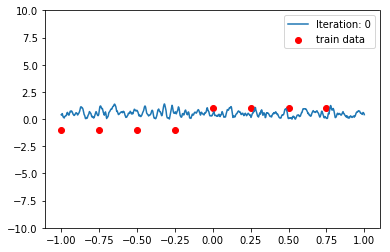

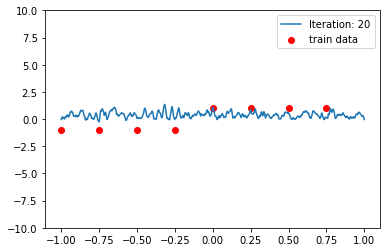

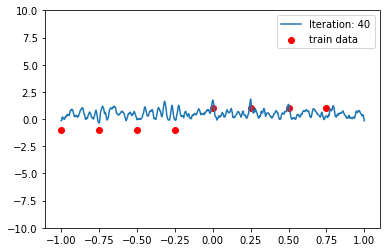

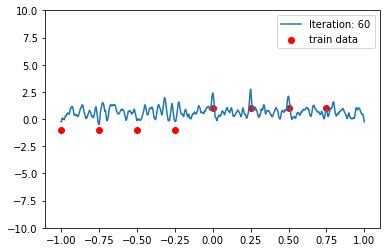

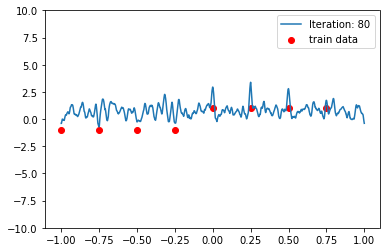

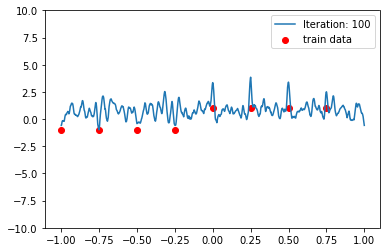

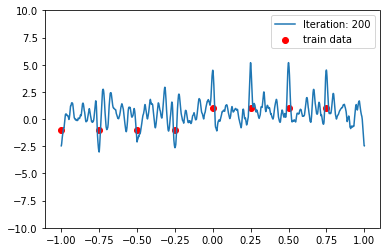

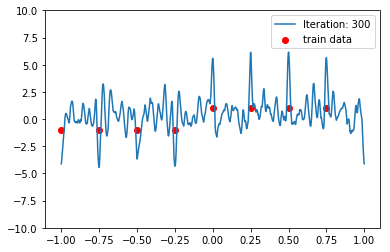

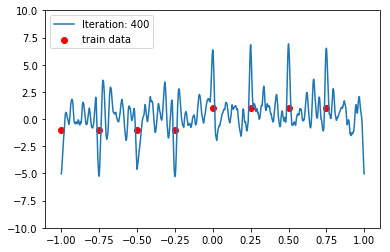

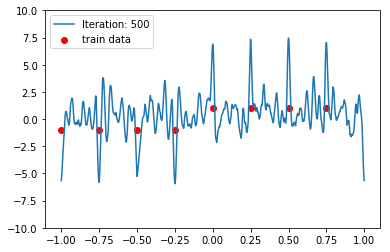

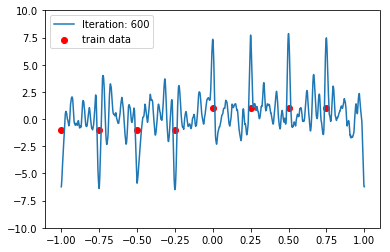

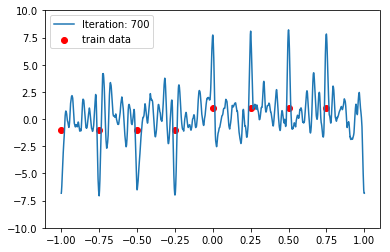

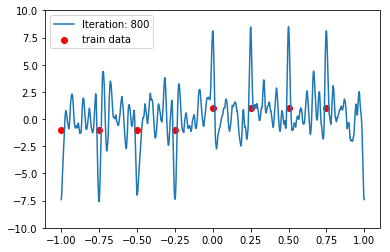

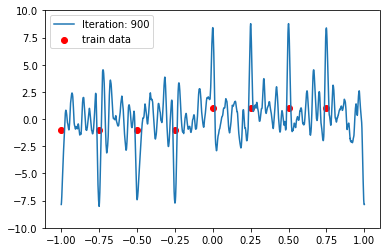

In [30]:
#plt.plot(x_train, y_train_ogi.flatten(),  color = "blue", linewidth=0, marker="D", markersize=5, label = 'Train data', alpha = 0.75 )

for (idx, preds) in enumerate(preds_list_smaller):
    label = "Iteration: " + str(indices[idx])
    plt.scatter(x_train, y_train_ogi, label = 'train data', color = 'red')
    plt.plot(x_test, preds,'-', marker = 'x', markersize = 0, linewidth = 1.5, label = label)
    plt.ylim([-10,10])
    plt.legend()
    plt.show()

# Processing feats and plotting

In [31]:
feats_select = feat_list[-100]

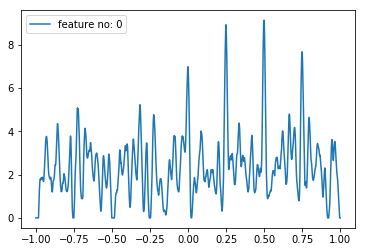

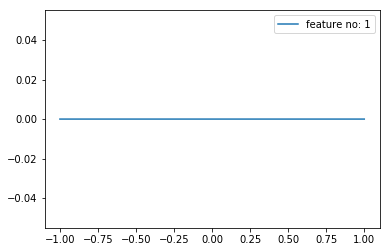

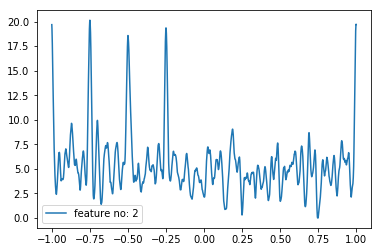

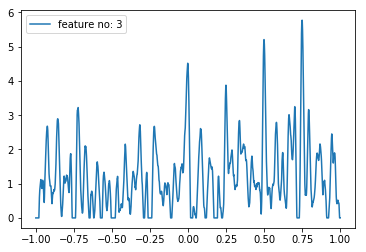

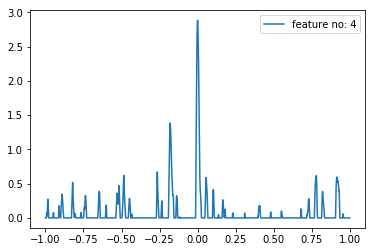

In [32]:
for i in range(5):
    feat_i = feats_select[:, i]
    label = "feature no: " + str(i)
    plt.plot(x_test, feat_i, label = label)
    plt.legend()
    plt.show()